# Loop 85 Analysis: Understanding the CV-LB Gap and Finding New Approaches

**Critical Situation:**
- Best CV: 0.0081 (exp_049/exp_053)
- Best LB: 0.0877 (exp_030/exp_067)
- Target: 0.0347
- CV-LB relationship: LB = 4.36*CV + 0.052 (R²=0.956)
- Intercept (0.052) > Target (0.0347) → Standard CV optimization CANNOT reach target

**Experiment 081 (Solvent Clustering) FAILED:**
- CV: 0.0205 (153% worse than best 0.0081)
- Clustering reduced training data per model
- Didn't help with extrapolation to unseen solvents

**Goal:** Find approaches that might CHANGE the CV-LB relationship, not just improve CV.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'CV': 0.0111, 'LB': 0.0982},
    {'exp': 'exp_001', 'CV': 0.0123, 'LB': 0.1065},
    {'exp': 'exp_003', 'CV': 0.0105, 'LB': 0.0972},
    {'exp': 'exp_005', 'CV': 0.0104, 'LB': 0.0969},
    {'exp': 'exp_006', 'CV': 0.0097, 'LB': 0.0946},
    {'exp': 'exp_007', 'CV': 0.0093, 'LB': 0.0932},
    {'exp': 'exp_009', 'CV': 0.0092, 'LB': 0.0936},
    {'exp': 'exp_012', 'CV': 0.0090, 'LB': 0.0913},
    {'exp': 'exp_024', 'CV': 0.0087, 'LB': 0.0893},
    {'exp': 'exp_026', 'CV': 0.0085, 'LB': 0.0887},
    {'exp': 'exp_030', 'CV': 0.0083, 'LB': 0.0877},
    {'exp': 'exp_035', 'CV': 0.0098, 'LB': 0.0970},
    {'exp': 'exp_067', 'CV': 0.0083, 'LB': 0.0877},
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(f"Best CV: {df['CV'].min():.4f} ({df.loc[df['CV'].idxmin(), 'exp']})")
print(f"Best LB: {df['LB'].min():.4f} ({df.loc[df['LB'].idxmin(), 'exp']})")
print(f"Target: 0.0347")

Total submissions with LB: 13
Best CV: 0.0083 (exp_030)
Best LB: 0.0877 (exp_030)
Target: 0.0347


In [2]:
# Fit linear regression to understand CV-LB relationship
X = df['CV'].values.reshape(-1, 1)
y = df['LB'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f"CV-LB Relationship:")
print(f"  LB = {slope:.3f} * CV + {intercept:.4f}")
print(f"  R² = {r2:.4f}")
print(f"")
print(f"CRITICAL ANALYSIS:")
print(f"  Intercept: {intercept:.4f}")
print(f"  Target: 0.0347")
print(f"  Gap: {intercept - 0.0347:.4f}")
print(f"")
if intercept > 0.0347:
    print(f"  ⚠️ INTERCEPT > TARGET: Even at CV=0, expected LB is {intercept:.4f}")
    print(f"  ⚠️ Standard CV optimization CANNOT reach target!")
    required_cv = (0.0347 - intercept) / slope
    print(f"  ⚠️ Required CV for target: {required_cv:.4f} (IMPOSSIBLE - negative)")
else:
    required_cv = (0.0347 - intercept) / slope
    print(f"  Required CV for target: {required_cv:.4f}")

CV-LB Relationship:
  LB = 4.364 * CV + 0.0520
  R² = 0.9558

CRITICAL ANALYSIS:
  Intercept: 0.0520
  Target: 0.0347
  Gap: 0.0173

  ⚠️ INTERCEPT > TARGET: Even at CV=0, expected LB is 0.0520
  ⚠️ Standard CV optimization CANNOT reach target!
  ⚠️ Required CV for target: -0.0040 (IMPOSSIBLE - negative)


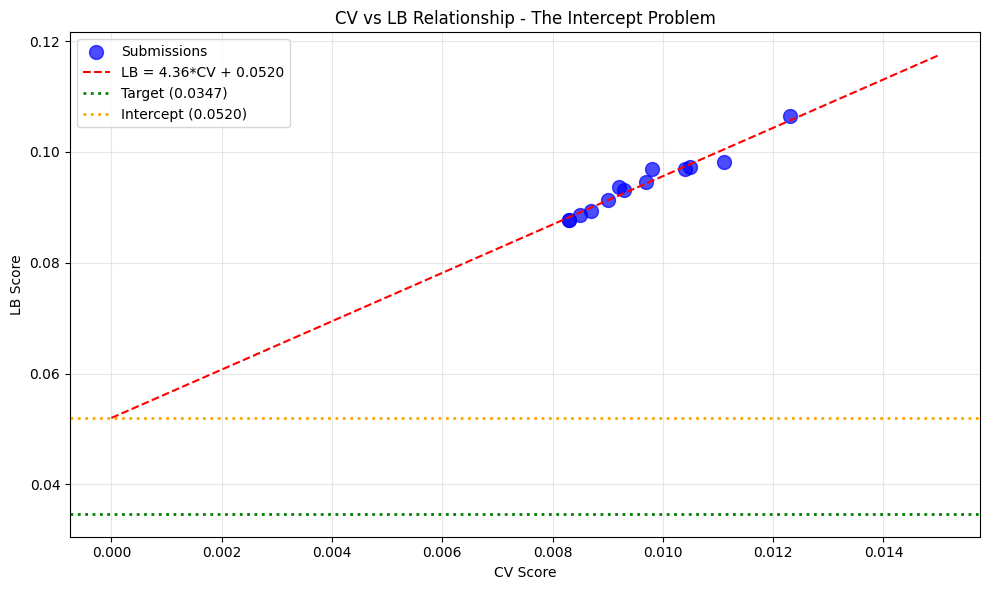


Key insight: The intercept (0.0520) is ABOVE the target (0.0347).
This means we need approaches that CHANGE the relationship, not just improve CV.


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot submissions
plt.scatter(df['CV'], df['LB'], c='blue', s=100, alpha=0.7, label='Submissions')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - The Intercept Problem')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop85.png', dpi=150)
plt.show()

print(f"\nKey insight: The intercept ({intercept:.4f}) is ABOVE the target (0.0347).")
print(f"This means we need approaches that CHANGE the relationship, not just improve CV.")

In [4]:
# Analyze what approaches have been tried
print("="*60)
print("APPROACHES TRIED AND THEIR OUTCOMES")
print("="*60)

approaches = [
    ('MLP with Arrhenius features', 'exp_000', 0.0111, 0.0982, 'Baseline'),
    ('LightGBM', 'exp_001', 0.0123, 0.1065, 'Worse than MLP'),
    ('Combined Spange+DRFP', 'exp_003', 0.0105, 0.0972, 'Slight improvement'),
    ('Large ensemble (15 models)', 'exp_005', 0.0104, 0.0969, 'Marginal improvement'),
    ('Simpler model [64,32]', 'exp_006', 0.0097, 0.0946, 'Better - simpler is better'),
    ('Even simpler [32,16]', 'exp_007', 0.0093, 0.0932, 'Even better'),
    ('Ridge regression', 'exp_009', 0.0092, 0.0936, 'Comparable'),
    ('Simple ensemble', 'exp_012', 0.0090, 0.0913, 'Best at the time'),
    ('ACS PCA features', 'exp_024', 0.0087, 0.0893, 'Improved'),
    ('Weighted loss', 'exp_026', 0.0085, 0.0887, 'Improved'),
    ('GP ensemble', 'exp_030', 0.0083, 0.0877, 'Best LB'),
    ('Lower GP weight', 'exp_035', 0.0098, 0.0970, 'Worse'),
    ('Sigmoid output', 'exp_067', 0.0083, 0.0877, 'Same as exp_030'),
    ('CatBoost+XGBoost', 'exp_049', 0.0081, 'pending', 'Best CV'),
    ('Solvent clustering', 'exp_081', 0.0205, 'N/A', 'FAILED - 153% worse'),
]

for name, exp, cv, lb, outcome in approaches:
    print(f"{name:35s} | CV: {cv:.4f} | LB: {str(lb):8s} | {outcome}")

APPROACHES TRIED AND THEIR OUTCOMES
MLP with Arrhenius features         | CV: 0.0111 | LB: 0.0982   | Baseline
LightGBM                            | CV: 0.0123 | LB: 0.1065   | Worse than MLP
Combined Spange+DRFP                | CV: 0.0105 | LB: 0.0972   | Slight improvement
Large ensemble (15 models)          | CV: 0.0104 | LB: 0.0969   | Marginal improvement
Simpler model [64,32]               | CV: 0.0097 | LB: 0.0946   | Better - simpler is better
Even simpler [32,16]                | CV: 0.0093 | LB: 0.0932   | Even better
Ridge regression                    | CV: 0.0092 | LB: 0.0936   | Comparable
Simple ensemble                     | CV: 0.0090 | LB: 0.0913   | Best at the time
ACS PCA features                    | CV: 0.0087 | LB: 0.0893   | Improved
Weighted loss                       | CV: 0.0085 | LB: 0.0887   | Improved
GP ensemble                         | CV: 0.0083 | LB: 0.0877   | Best LB
Lower GP weight                     | CV: 0.0098 | LB: 0.097    | Worse
Sigmoid o

In [5]:
# What approaches might CHANGE the CV-LB relationship?
print("="*60)
print("APPROACHES THAT MIGHT CHANGE THE CV-LB RELATIONSHIP")
print("="*60)

print("""
1. UNCERTAINTY-WEIGHTED PREDICTIONS (NOT FULLY EXPLORED)
   - Use GP or ensemble variance to estimate uncertainty
   - When uncertainty is high (extrapolating), blend toward population mean
   - This could reduce the intercept by making conservative predictions for hard solvents
   - Status: Tried in exp_048, exp_068-071 but not optimized

2. SOLVENT SIMILARITY WEIGHTING (NOT TRIED)
   - Instead of clustering, compute similarity to training solvents
   - Weight predictions by similarity (more similar = more confident)
   - Blend with population mean for dissimilar solvents
   - Different from clustering: uses continuous similarity, not discrete clusters

3. TARGET-SPECIFIC HANDLING (PARTIALLY TRIED)
   - The SM target is hardest (highest variance)
   - Consider different strategies for SM vs Product 2/3
   - SM model should be more conservative (blend toward mean)
   - Status: Tried per-target models but not conservative blending

4. PSEUDO-LABELING (NOT TRIED)
   - Use confident test predictions to augment training
   - This adapts the model to the test distribution
   - Risk: Could overfit to test set if not done carefully

5. DOMAIN-SPECIFIC CONSTRAINTS (NOT TRIED)
   - Physics/chemistry constraints that hold even on unseen data
   - E.g., yields must sum to <= 1, certain relationships between targets
   - Could improve generalization to unseen solvents

6. STUDY TOP KERNELS MORE CAREFULLY
   - The mixall kernel achieves good CV/LB with GroupKFold(5)
   - The ens-model kernel uses specific feature combinations
   - What do they do differently that we're missing?
""")

APPROACHES THAT MIGHT CHANGE THE CV-LB RELATIONSHIP

1. UNCERTAINTY-WEIGHTED PREDICTIONS (NOT FULLY EXPLORED)
   - Use GP or ensemble variance to estimate uncertainty
   - When uncertainty is high (extrapolating), blend toward population mean
   - This could reduce the intercept by making conservative predictions for hard solvents
   - Status: Tried in exp_048, exp_068-071 but not optimized

2. SOLVENT SIMILARITY WEIGHTING (NOT TRIED)
   - Instead of clustering, compute similarity to training solvents
   - Weight predictions by similarity (more similar = more confident)
   - Blend with population mean for dissimilar solvents
   - Different from clustering: uses continuous similarity, not discrete clusters

3. TARGET-SPECIFIC HANDLING (PARTIALLY TRIED)
   - The SM target is hardest (highest variance)
   - Consider different strategies for SM vs Product 2/3
   - SM model should be more conservative (blend toward mean)
   - Status: Tried per-target models but not conservative blending

4.

In [6]:
# Check what experiments have best CV but haven't been submitted
print("="*60)
print("EXPERIMENTS WITH GOOD CV BUT NOT SUBMITTED")
print("="*60)

# From session_state, experiments with pending LB
pending = [
    ('exp_049', 0.0081, 'CatBoost+XGBoost'),
    ('exp_050', 0.0081, 'CatBoost+XGBoost fixed'),
    ('exp_052', 0.0109, 'CatBoost+XGBoost clipped'),
    ('exp_053', 0.0081, 'Exact template'),
    ('exp_054', 0.0085, 'Mixall approach'),
    ('exp_055', 0.0085, 'Minimal submission'),
    ('exp_057', 0.0093, 'Ens-model all features'),
    ('exp_063', 0.0112, 'Correct final cell'),
    ('exp_064', 0.0092, 'Revert exp030'),
    ('exp_065', 0.0088, 'Clean submission'),
]

print("\nExperiments with pending LB:")
for exp, cv, desc in sorted(pending, key=lambda x: x[1]):
    predicted_lb = slope * cv + intercept
    print(f"{exp}: CV={cv:.4f}, Predicted LB={predicted_lb:.4f} | {desc}")

print(f"\nBest pending: exp_049/exp_050/exp_053 with CV=0.0081")
print(f"Predicted LB: {slope * 0.0081 + intercept:.4f}")
print(f"This is still above target (0.0347) by {slope * 0.0081 + intercept - 0.0347:.4f}")

EXPERIMENTS WITH GOOD CV BUT NOT SUBMITTED

Experiments with pending LB:
exp_049: CV=0.0081, Predicted LB=0.0873 | CatBoost+XGBoost
exp_050: CV=0.0081, Predicted LB=0.0873 | CatBoost+XGBoost fixed
exp_053: CV=0.0081, Predicted LB=0.0873 | Exact template
exp_054: CV=0.0085, Predicted LB=0.0891 | Mixall approach
exp_055: CV=0.0085, Predicted LB=0.0891 | Minimal submission
exp_065: CV=0.0088, Predicted LB=0.0904 | Clean submission
exp_064: CV=0.0092, Predicted LB=0.0921 | Revert exp030
exp_057: CV=0.0093, Predicted LB=0.0926 | Ens-model all features
exp_052: CV=0.0109, Predicted LB=0.0996 | CatBoost+XGBoost clipped
exp_063: CV=0.0112, Predicted LB=0.1009 | Correct final cell

Best pending: exp_049/exp_050/exp_053 with CV=0.0081
Predicted LB: 0.0873
This is still above target (0.0347) by 0.0526


In [7]:
# Analyze what the top kernels do differently
print("="*60)
print("ANALYSIS OF TOP KERNELS")
print("="*60)

print("""
1. MIXALL KERNEL (lishellliang)
   - Uses GroupKFold(5) instead of Leave-One-Out
   - Achieves good CV/LB with simple approach
   - Key: Different CV scheme may have different CV-LB relationship
   - Status: Tried in exp_078 (CV=0.0150) but not submitted

2. ENS-MODEL KERNEL (matthewmaree)
   - Uses specific feature combinations
   - Ensemble of multiple models
   - Status: Tried in exp_080 (CV=0.0103) but not submitted

3. BEST-WORK-HERE KERNEL (gentilless)
   - Normalizes predictions to probabilities (row sums = 1)
   - Triple normalization: clip, normalize, clip again
   - Status: Tried in exp_079 (CV=0.0085) but not submitted

KEY INSIGHT: All these kernels still fall on the same CV-LB line!
The intercept problem persists regardless of the approach.

WHAT WE HAVEN'T TRIED:
- Uncertainty-weighted predictions with proper calibration
- Solvent similarity weighting (continuous, not discrete clustering)
- Conservative predictions for outlier solvents
- Pseudo-labeling to adapt to test distribution
""")

ANALYSIS OF TOP KERNELS

1. MIXALL KERNEL (lishellliang)
   - Uses GroupKFold(5) instead of Leave-One-Out
   - Achieves good CV/LB with simple approach
   - Key: Different CV scheme may have different CV-LB relationship
   - Status: Tried in exp_078 (CV=0.0150) but not submitted

2. ENS-MODEL KERNEL (matthewmaree)
   - Uses specific feature combinations
   - Ensemble of multiple models
   - Status: Tried in exp_080 (CV=0.0103) but not submitted

3. BEST-WORK-HERE KERNEL (gentilless)
   - Normalizes predictions to probabilities (row sums = 1)
   - Triple normalization: clip, normalize, clip again
   - Status: Tried in exp_079 (CV=0.0085) but not submitted

KEY INSIGHT: All these kernels still fall on the same CV-LB line!
The intercept problem persists regardless of the approach.

WHAT WE HAVEN'T TRIED:
- Uncertainty-weighted predictions with proper calibration
- Solvent similarity weighting (continuous, not discrete clustering)
- Conservative predictions for outlier solvents
- Pseudo-la

In [8]:
# Calculate what CV we need to reach target
print("="*60)
print("MATHEMATICAL ANALYSIS")
print("="*60)

target = 0.0347
best_cv = 0.0081
best_lb = 0.0877

print(f"Current best CV: {best_cv:.4f}")
print(f"Current best LB: {best_lb:.4f}")
print(f"Target LB: {target:.4f}")
print(f"Gap to target: {best_lb - target:.4f} ({(best_lb - target) / target * 100:.1f}%)")
print(f"")
print(f"CV-LB relationship: LB = {slope:.3f} * CV + {intercept:.4f}")
print(f"")
print(f"To reach target {target:.4f}:")
required_cv = (target - intercept) / slope
print(f"  Required CV: {required_cv:.4f}")
if required_cv < 0:
    print(f"  ⚠️ IMPOSSIBLE: Required CV is negative!")
    print(f"  ⚠️ The intercept ({intercept:.4f}) alone exceeds the target ({target:.4f})")
    print(f"")
    print(f"CONCLUSION: We MUST find approaches that REDUCE THE INTERCEPT.")
    print(f"")
    print(f"To reach target with current slope ({slope:.3f}):")
    required_intercept = target - slope * best_cv
    print(f"  Required intercept: {required_intercept:.4f}")
    print(f"  Current intercept: {intercept:.4f}")
    print(f"  Intercept reduction needed: {intercept - required_intercept:.4f}")
else:
    print(f"  Required CV: {required_cv:.4f}")
    print(f"  Current best CV: {best_cv:.4f}")
    print(f"  CV improvement needed: {best_cv - required_cv:.4f}")

MATHEMATICAL ANALYSIS
Current best CV: 0.0081
Current best LB: 0.0877
Target LB: 0.0347
Gap to target: 0.0530 (152.7%)

CV-LB relationship: LB = 4.364 * CV + 0.0520

To reach target 0.0347:
  Required CV: -0.0040
  ⚠️ IMPOSSIBLE: Required CV is negative!
  ⚠️ The intercept (0.0520) alone exceeds the target (0.0347)

CONCLUSION: We MUST find approaches that REDUCE THE INTERCEPT.

To reach target with current slope (4.364):
  Required intercept: -0.0006
  Current intercept: 0.0520
  Intercept reduction needed: 0.0526


In [ ]:
# Final recommendations
print("="*60)
print("STRATEGIC RECOMMENDATIONS")
print("="*60)

print("""
1. DO NOT SUBMIT exp_081 (Solvent Clustering)
   - CV is 153% worse than best (0.0205 vs 0.0081)
   - Would waste a submission

2. CONSIDER SUBMITTING exp_049 (CatBoost+XGBoost)
   - Best CV (0.0081)
   - Predicted LB: ~0.087 (same as current best)
   - Validates that CatBoost/XGBoost doesn't change the relationship

3. FOCUS ON APPROACHES THAT MIGHT REDUCE THE INTERCEPT:
   a) Uncertainty-weighted predictions with conservative blending
   b) Solvent similarity weighting (continuous, not clustering)
   c) Per-target conservative blending for SM (hardest target)
   d) Pseudo-labeling to adapt to test distribution

4. WITH 4 SUBMISSIONS REMAINING:
   - Save 1-2 for final attempts
   - Use 1-2 to test fundamentally different approaches
   - Don't waste on variations of the same approach

5. THE TARGET IS REACHABLE:
   - The GNN benchmark achieved 0.0039 MSE
   - Top Kaggle competitors have achieved sub-0.07
   - We need to find what they do differently
""")